In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


In [4]:
def fibre_propagation(U0, wvl, x, z, refractive_index):
    nx = U0.shape[0]
    k = 2 * torch.pi / wvl

    dx = torch.abs(x[1] - x[0])
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)

    U_out = torch.zeros(nx, z.shape[0], device=U0.device) + 0j
    U_out[:, 0] = U0 

    absorbing_window = torch.exp(-(x / (40e-6))**20)
    dz = z[1] - z[0]
    
    H = torch.exp(1j * k * dz * torch.sqrt(1 + 0j - (wvl * fx) ** 2))
    for i in range(1, z.shape[0]):
        U_in = U_out[:, i - 1]
        phase_shift = torch.exp(1j * k * dz * refractive_index[:, i - 1]) * absorbing_window
        U1 = torch.fft.fftshift(torch.fft.ifft(torch.fft.fft(torch.fft.ifftshift(U_out[:, i - 1] * phase_shift)) * H))
        U_out[:, i] = U1
        

    return U_out

# CW_11
You are given the following scenario. 

Create two fibres (diameter around 2µm) and place them next to each other. Propagate the field through the fibres and observe the intensity. Start with a refractive index difference of 0.05.

As a initial beam, use `torch.exp(-(x-0e-6)**2 / (2 * 1e-6)**2)`

- What happens when the fibres are very close and what happens when they are further away. 
- Try to vary also the size and location of the incoming beam.
- What happens with a different refractive index difference of the core and cladding?

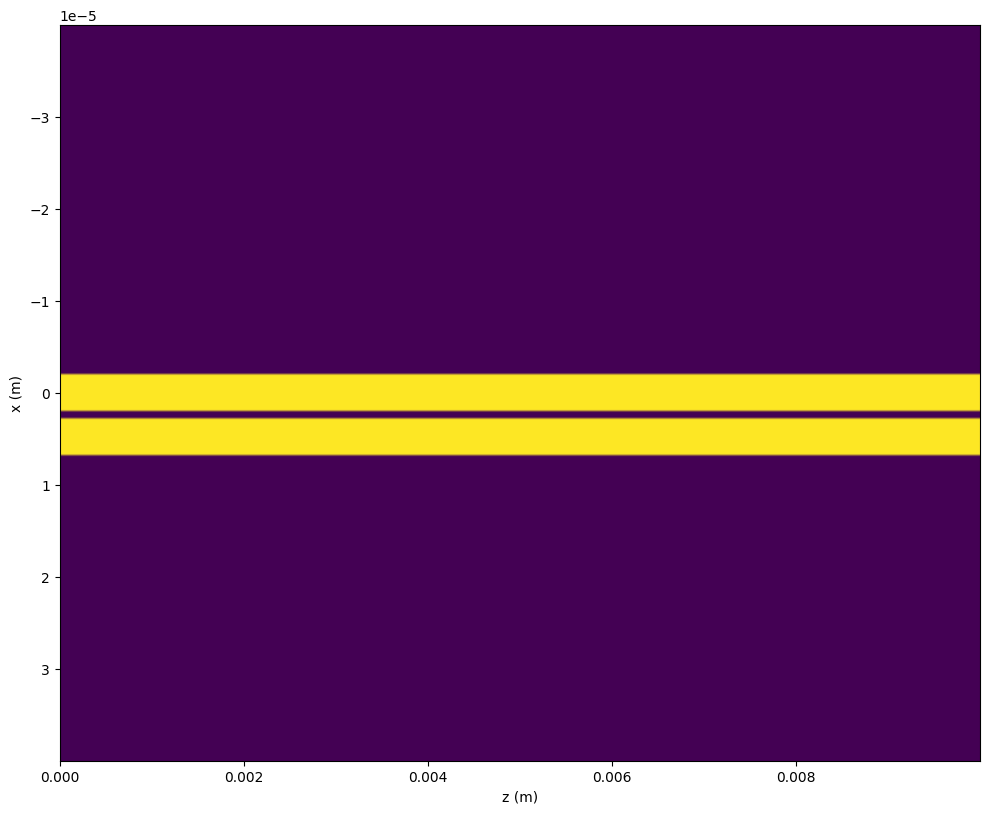

In [7]:
refractive_index = torch.zeros(200, 10_000)
wvl = 633e-9

x = torch.linspace(-40e-6, 40e-6, 200)
z = torch.linspace(0e-6, 10_000e-6, 10_000)

width = 2e-6
pos1 = 0e-6
pos2 = 5e-6
refractive_index[:, :] = 0.05 * ((torch.abs(x - pos1) < width) + (torch.abs(x - pos2) < width)).reshape(200, 1)


# Plot with proper axis labels and equal aspect ratio
plt.figure(figsize=(10, 10))
im = plt.imshow(refractive_index.cpu().numpy(), 
                extent=[z[0], z[-1], x[-1], x[0]],  # [left, right, bottom, top]
                aspect=100,
                cmap='viridis')
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.tight_layout()
plt.show()

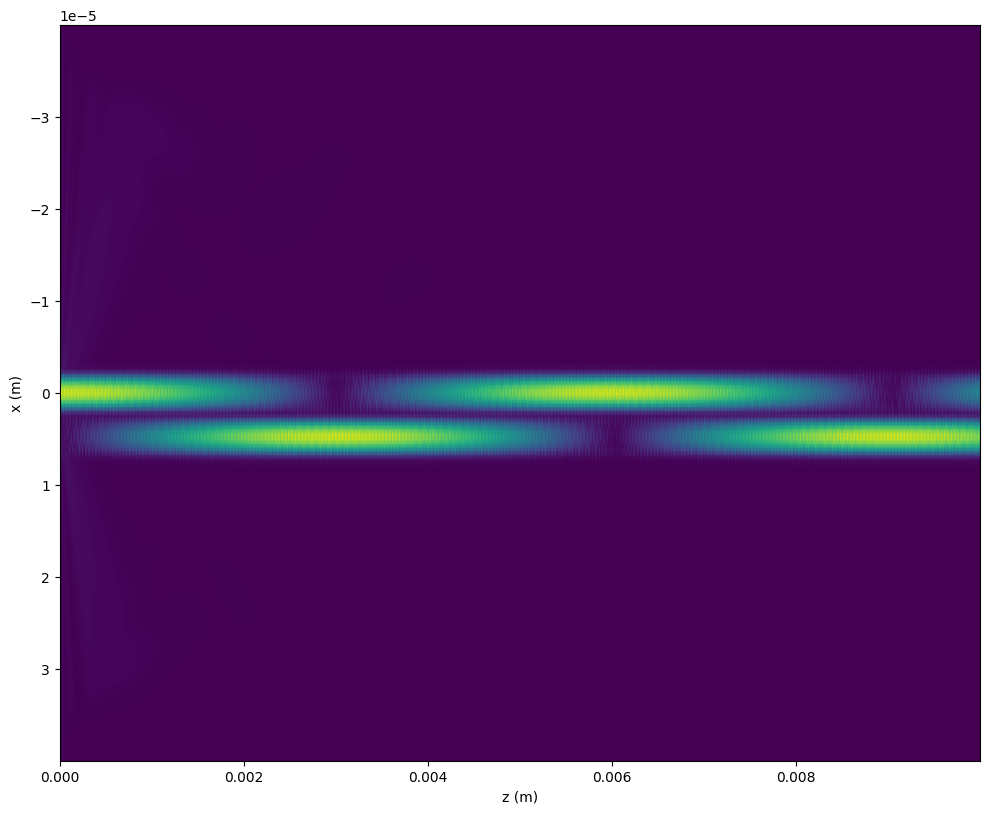

In [8]:
U0 = torch.exp(-(x-0e-6)**2 / (2 * 1e-6)**2)
U_prop = fibre_propagation(U0, wvl, x, z, refractive_index)


# Plot with proper axis labels and equal aspect ratio
plt.figure(figsize=(10, 10))
im = plt.imshow(torch.abs(U_prop)**1, 
                extent=[z[0], z[-1], x[-1], x[0]],  # [left, right, bottom, top]
                aspect=100,
                cmap='viridis')
plt.xlabel("z (m)")
plt.ylabel("x (m)")
plt.tight_layout()
plt.show()